### This jupyter notebook contains practical assignment for the students "Forecasting stock prices"

**Author : Umidjon Sattorov. Machine Learning engineer**

**Прогнозирование** – это одна из самых распространённых практик, которой ежедневно занимаются дата-саентисты, исследователи и инвесторы. Это самый мощный инструмент, которым может обладать бизнесмен. Ведь когда инвестор, располагающий капиталом, хочет открыть новый бизнес в надежде получить значительную прибыль, он должен уметь прогнозировать, сколько денег этот бизнес сможет принести за определённый промежуток времени. По крайней мере, он должен быть способен оценить, будет ли бизнес прибыльным или нет.

Трейдерам и инвесторам также необходимо прогнозировать будущую цену товара или актива, которым они торгуют. Обладая только этим навыком, инвесторы и трейдеры могут зарабатывать на рынке. У них нет сервисного бизнеса, который получает прибыль от предоставления клиентам качественных услуг, но они рискуют своими деньгами, принимая решения в финансовом мире.

Большинство стратегий, которые сегодня используют ручные трейдеры, не предсказывают будущую цену актива, а лишь направление движения цены. Да, есть стратегии, например «GANN», которые пытаются предсказать, насколько может вырасти или упасть цена актива. Также другие стратегии, такие как индикатор RSI, могут использоваться подобным образом, но чаще всего они дают сбой (требуется бэктестинг).

Одним из жизнеспособных решений для прогнозирования цены актива могут быть модели машинного обучения, такие как линейная регрессия (или полиномиальная регрессия). В этой лабораторной работе мы проверим, может ли линейная регрессия помочь нам прогнозировать будущую цену актива и сможем ли мы использовать её для торговли в будущем.

В качестве актива мы возьмём цены AAPL (акции компании Apple). Это одна из самых торгуемых и популярных акций на рынке, так как большинство инвесторов верят в светлое будущее этой компании.

**Акции** представляют собой доли собственности в компании. Когда вы покупаете акцию, вы становитесь акционером и владеете частью этой компании. Акции торгуются на биржах, таких как NYSE или NASDAQ, а их цены колеблются в зависимости от результатов деятельности компании, рыночных условий и спроса со стороны инвесторов. Инвесторы покупают акции, чтобы потенциально получать прибыль за счёт роста цен (капитальный прирост) или регулярных выплат, называемых **дивидендами**.

___

In [3]:
%pip install mplfinance


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Importing necessary libraries
# Data analysis and preprocessing
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import mplfinance as mpf
from scipy import stats

# ML models
from sklearn.linear_model import LinearRegression

# Validation of models with metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [10]:
df = pd.read_csv('apple_stock_real_price.csv', delimiter='|', index_col=0)
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,2011-02-04,12.27,12.38,12.27,12.38,65128,0,302137836
1,2011-02-07,12.42,12.62,12.42,12.57,86674,0,433507340
2,2011-02-08,12.63,12.70,12.58,12.69,74585,0,357273868
3,2011-02-09,12.69,12.82,12.67,12.79,96735,0,461625052
4,2011-02-10,12.76,12.86,12.43,12.66,198041,0,891855216


___

#### Fundamental analysis of the market data

In [11]:
# Проверьте типы данных каждого столбца и при необходимости измените их.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3650 entries, 0 to 3649
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         3650 non-null   object 
 1   open         3650 non-null   float64
 2   high         3650 non-null   float64
 3   low          3650 non-null   float64
 4   close        3650 non-null   float64
 5   tick_volume  3650 non-null   int64  
 6   spread       3650 non-null   int64  
 7   real_volume  3650 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 256.6+ KB


In [14]:
len(df)

3650

In [15]:
# Это будет всего лишь практика прогнозирования цены закрытия акции, удалите другие признаки.
X = pd.DataFrame({'close': df['close']})
X

,close
0,12.38
1,12.57
2,12.69
3,12.79
4,12.66
...,...
3645,230.89
3646,230.56
3647,226.01
3648,224.90


In [19]:
# Сохраните данные о времени и преобразуйте их в объект datetime для последующей визуализации (удалите первые четыре строки данных).
df["time"] = pd.to_datetime(df["time"])
time_data = df['time'].iloc[3:]
time_data

3      2011-02-09
4      2011-02-10
5      2011-02-11
6      2011-02-14
7      2011-02-15
          ...    
3645   2025-08-18
3646   2025-08-19
3647   2025-08-20
3648   2025-08-21
3649   2025-08-22
Name: time, Length: 3647, dtype: datetime64[ns]

In [20]:
# Разделите данные о времени на обучающую и тестовую части.
time_data_train = time_data.head(3000)
time_data_test = time_data.tail(645)

Поскольку у вас есть только один признак, и задача заключается в прогнозировании следующего значения этого признака (цены закрытия акции), подумайте, что вы будете использовать для предсказания следующего значения этого признака, прежде чем продолжить.

___

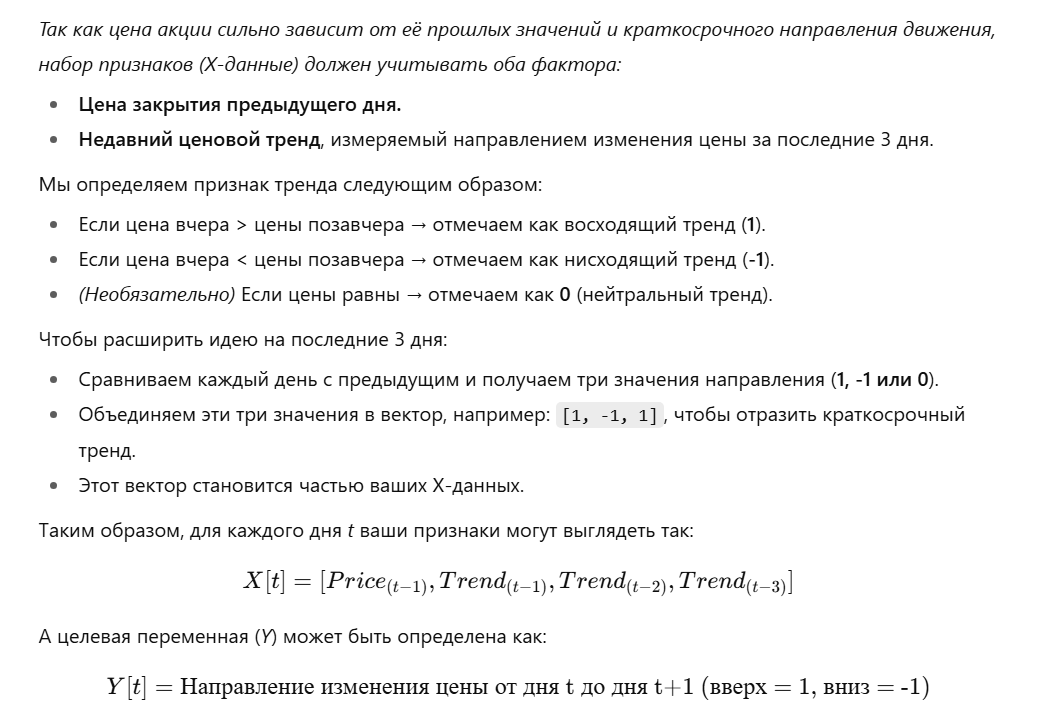

In [76]:
# Создание признака X (используйте функцию shift() для датафреймов)
X = pd.DataFrame({'prev_close': df['close'].shift(1)})
X

,prev_close
0,NaN
1,12.38
2,12.57
3,12.69
4,12.79
...,...
3645,231.59
3646,230.89
3647,230.56
3648,226.01


In [77]:
result = []
for i in range(1, 3649):
    a = df.iloc[i, 4]
    b = df.iloc[i-1, 4]
    if a > b:
        result.append(1)
    else:
        result.append(-1)
X = X.dropna()
X = X.drop(index=1, axis=0)
X['three_days_trend'] = result
X.reset_index(inplace=True)
X.drop(columns=['index'], inplace=True)
X

,prev_close,three_days_trend
0,12.57,1
1,12.69,1
2,12.79,1
3,12.66,-1
4,12.75,1
...,...,...
3643,231.59,-1
3644,230.89,-1
3645,230.56,-1
3646,226.01,-1


In [78]:
y = X['prev_close']
y

0        12.57
1        12.69
2        12.79
3        12.66
4        12.75
         ...  
3643    231.59
3644    230.89
3645    230.56
3646    226.01
3647    224.90
Name: prev_close, Length: 3648, dtype: float64

___

* Разделите набор данных на обучающую и тестовую выборки

In [79]:
# Первые 3000 строк используем для обучения, а оставшиеся данные — для валидации.
X_train = X.head(3000)
X_test = X.tail(645)
y_train = y.head(3000)
y_test = y.tail(645)

In [82]:
# Train Machine Learning model using Linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X = X_train, y = y_train)

# Validation of models performance
y_train_pred = lr.predict(X = X_train)
y_test_pred = lr.predict(X = X_test)

# Metrics
print(f"MSE error in training data : {mean_squared_error(y_true = y_train, y_pred = y_train_pred)}")
print(f"MAE error in training data : {mean_absolute_error(y_true = y_train, y_pred = y_train_pred)}")
print(f"MSL error in training data : {mean_squared_log_error(y_true = y_train, y_pred = y_train_pred)}")

print(f"MSE error in test data : {mean_squared_error(y_true = y_test, y_pred = y_test_pred)}")
print(f"MAE error in test data : {mean_absolute_error(y_true = y_test, y_pred = y_test_pred)}")
print(f"MSL error in test data : {mean_squared_log_error(y_true = y_test, y_pred = y_test_pred)}")

MSE error in training data : 0.0
MAE error in training data : 0.0
MSL error in training data : 0.0
MSE error in test data : 0.0
MAE error in test data : 0.0
MSL error in test data : 0.0


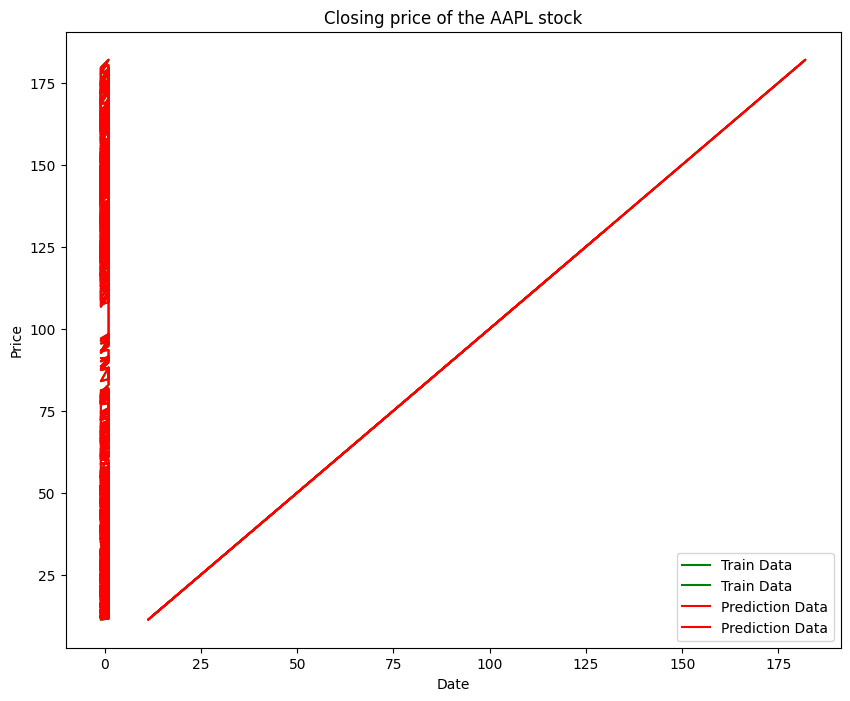

In [83]:
# Visualize real price and models prediction in linear graph for better visualization
plt.figure(figsize=(10,8))
plt.title("Closing price of the AAPL stock")
plt.plot(X_train, y_train, color='green', label='Train Data')
plt.plot(X_train, y_train_pred, color='red', label='Prediction Data')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

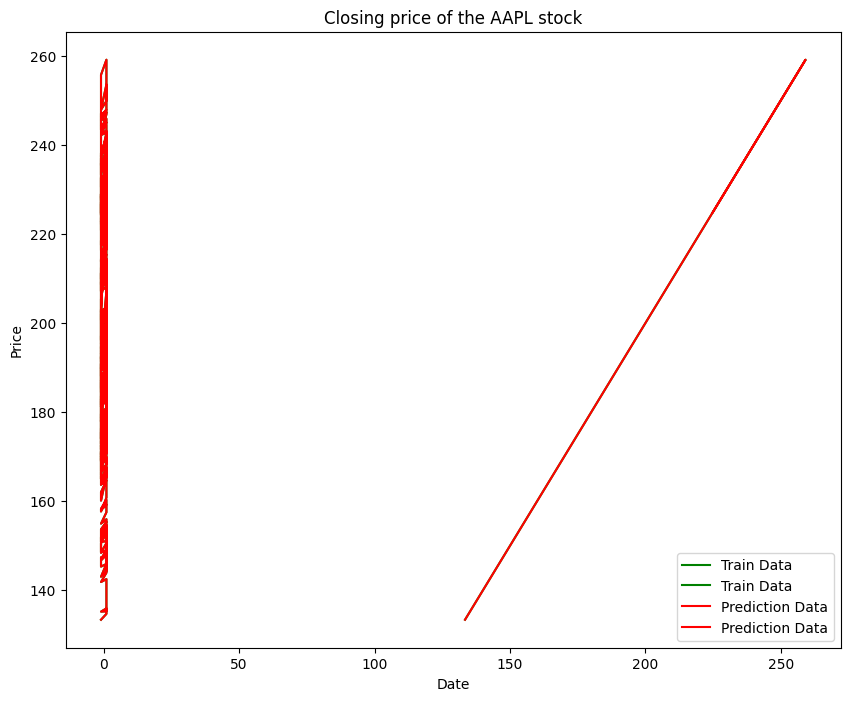

In [84]:
# Visualize real price and models prediction in linear graph for better visualization
plt.figure(figsize=(10,8))
plt.title("Closing price of the AAPL stock")
plt.plot(X_test, y_test, color='green', label='Train Data')
plt.plot(X_test, y_test_pred, color='red', label='Prediction Data')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Conclusion : However from the chart, model looks good performing, from the metrics change in training and test data. Model is a little bit overfitted to training data. Also the error of 2 $ for each day is worse for the stocks like this.